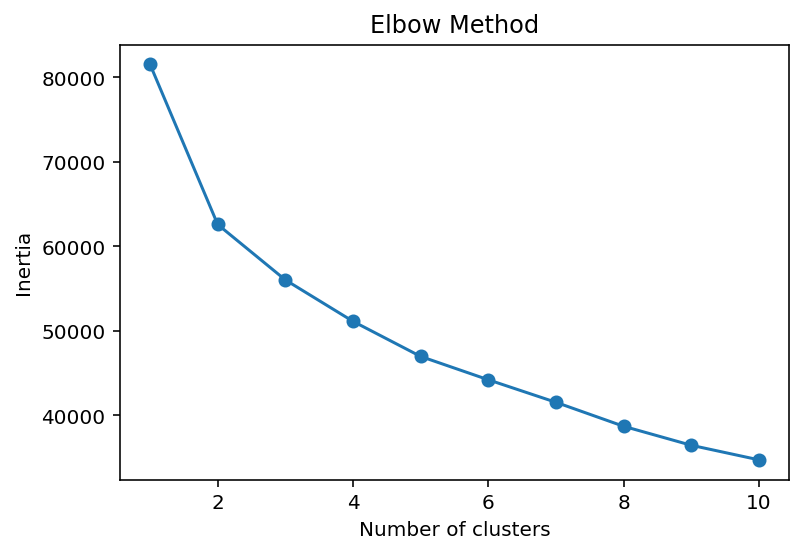

Mean distance between clusters: 8.49812550096995
Silhouette score: 0.2394034904620557


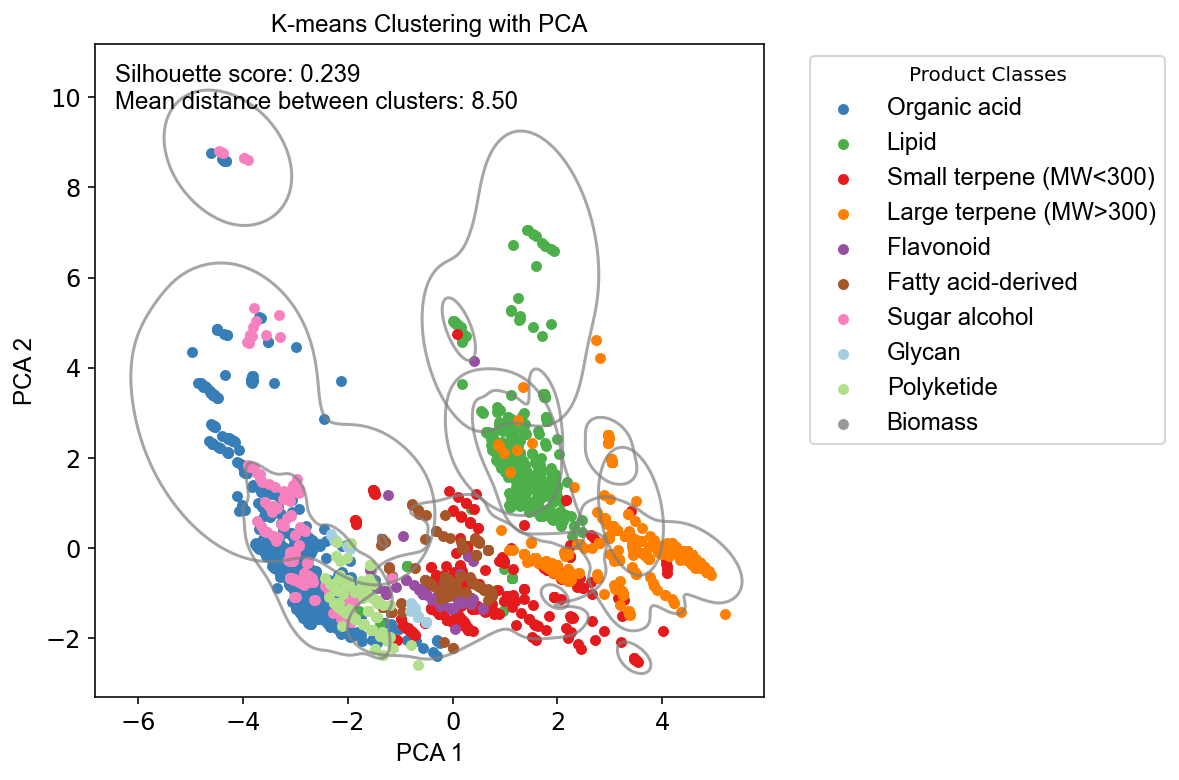

                                                       PCA1      PCA2
Carbon source 1 (category)                        -0.090720  0.342628
Carbon source 1 (g/L)                             -0.036691  0.123087
Carbon source 1 heat of combustion (kJ/mol)       -0.086069  0.322805
Carbon source 1 heat of combustion (kJ/g)         -0.125245  0.169053
Carbon source 2 (category)                         0.017509  0.231502
Carbon source 2 (g/L)                             -0.025358  0.300064
Carbon source 2 heat of combustion (kJ/mol)        0.012592  0.256282
Carbon source 2 heat of combustion (kJ/g)          0.003442  0.030265
Product Gibbs energy of formation in Equilibrator  0.290272 -0.066340
Number of carbon atoms in the product              0.330629  0.052799
Number of hydrogen atoms in the product            0.331644  0.102064
Number of oxygen atoms in the product             -0.223721  0.048259
MW of product (g/mol)                              0.243806  0.316911
Product titer (g/L) 

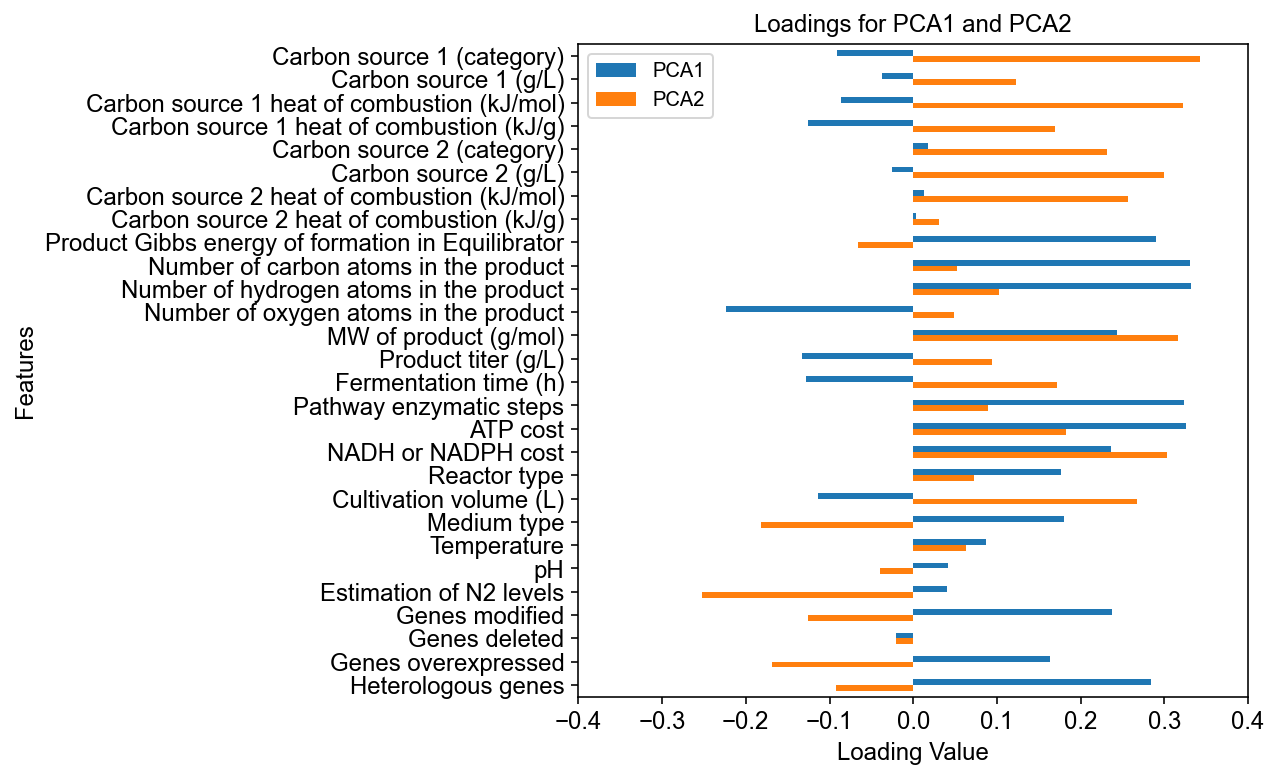

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but PCA was fitted with feature names")
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Load data from Excel
file_name = 'Database 0404 old.xlsx'
data = pd.read_excel(file_name, header=1)  # Headers are in the second row

# Count the semicolons in 'genes_modified_updated'
data['Genes modified'] = data['Genes modified'].fillna('').apply(lambda x: x.count(';'))

# Count the ones in 'gene_overexpression' and 'heterologous_gene'
data['Genes overexpressed'] = data['Genes overexpressed'].fillna('').apply(lambda x: str(x).count('1'))
data['Heterologous genes'] = data['Heterologous genes'].fillna('').apply(lambda x: str(x).count('1'))
data['Genes deleted'] = data['Genes deleted'].fillna('').apply(lambda x: str(x).count('1'))


# Scale the continuous variables
continuous_vars = data.drop(columns=['Product class','dataID', 'paper_number','product_name'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(continuous_vars)
# Impute all NaN data as zero
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaled_data = pd.DataFrame(imputer.fit_transform(scaled_data), columns=continuous_vars.columns)
# Apply PCA for visualization purposes
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Determine the optimal number of clusters using the elbow method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Choose the optimal number of clusters based on the elbow method and create a K-means model
optimal_clusters = 6  # Update this based on the elbow method graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data
data['cluster'] = clusters

from scipy.spatial.distance import pdist, squareform

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Compute the pairwise Euclidean distances between centroids
distances = pdist(centroids, 'euclidean')

# Calculate the mean distance between centroids
mean_distance = np.mean(distances)

print("Mean distance between clusters:", mean_distance)

from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(scaled_data, clusters)

print("Silhouette score:", score)

# Create a dictionary to map class numbers to class names
class_names = {
    1: 'Organic acid',
    2: 'Lipid',
    3: 'Small terpene (MW<300)',
    4: 'Large terpene (MW>300)',
    5: 'Flavonoid',
    6: 'Fatty acid-derived',
    7: 'Sugar alcohol',
    8: 'Glycan',
    9: 'Polyketide',
    10: 'Biomass'
}

# Replace the numeric class labels with their corresponding names
data['product_class_names'] = data['Product class'].map(class_names)

# Plot the PCA data with color-coded product classes
plt.figure(figsize=(6, 6))

# Create a custom color palette for the scatterplot
palette = [
    '#377eb8', # Blue
    '#4daf4a', # Green
    '#e41a1c', # Red
    '#ff7f00', # Orange
    '#984ea3', # Purple
    '#a65628', # Brown
    '#f781bf', # Pink
    '#a6cee3', # Light Blue
    '#b2df8a', # Light Green
    '#999999'  # Gray
]

font_size = 12
font_prop = FontProperties(family='Arial', size=font_size)

# Plot each class separately to create a custom legend
for i, class_name in class_names.items():
    class_points = pca_data[data['product_class_names'] == class_name]
    plt.scatter(class_points[:, 0], class_points[:, 1], color=palette[i-1], label=class_name, s=20)

plt.xlabel('PCA 1', fontproperties=font_prop)
plt.ylabel('PCA 2', fontproperties=font_prop)
plt.title('K-means Clustering with PCA', fontproperties=font_prop)

# Set the font properties for x-axis and y-axis tick labels
plt.tick_params(axis='both', which='major', labelsize=font_size)

# Draw contours around each cluster
for i in range(optimal_clusters):
    cluster_points = pca_data[clusters == i]
    sns.kdeplot(x=cluster_points[:, 0], y=cluster_points[:, 1], color='gray', levels=1, linewidths=1.5, alpha=0.7)

    # Add the silhouette score text inside the PCA figure
score_text = f"Silhouette score: {score:.3f}\nMean distance between clusters: {mean_distance:.2f}"
plt.text(0.03, 0.97, score_text, fontsize=12, transform=plt.gca().transAxes, verticalalignment='top',fontproperties=font_prop)

# Show the custom legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Product Classes', prop=font_prop)
plt.show()



# Display the loadings for PCA1 and PCA2
loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=continuous_vars.columns)
print(loadings)

# Change the tick font to Arial
plt.rcParams['font.family'] = 'Arial'
# Plot a horizontal bar graph of the loadings for PCA1 and PCA2
loadings.plot(kind='barh', figsize=(6, 6))
plt.title('Loadings for PCA1 and PCA2', fontproperties=font_prop)
plt.xlabel('Loading Value', fontproperties=font_prop)
plt.ylabel('Features', fontproperties=font_prop)

# Set the font properties for x-axis and y-axis tick labels
plt.tick_params(axis='both', which='major', labelsize=font_size)

# Scale the x-axis from -0.4 to 0.4
plt.xlim(-0.4, 0.4)

# Reverse the y-axis
plt.gca().invert_yaxis()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", message="X does not have valid feature names, but PCA was fitted with feature names")
import seaborn as sns
from matplotlib.font_manager import FontProperties

# Load data from Excel
file_name = 'Database 0404 new.xlsx'
data = pd.read_excel(file_name, header=1)  # Headers are in the second row

# Count the semicolons in 'genes_modified_updated'
data['Genes modified'] = data['Genes modified'].fillna('').apply(lambda x: x.count(';'))

# Count the ones in 'gene_overexpression' and 'heterologous_gene'
data['Genes overexpressed'] = data['Genes overexpressed'].fillna('').apply(lambda x: str(x).count('1'))
data['Heterologous genes'] = data['Heterologous genes'].fillna('').apply(lambda x: str(x).count('1'))
data['Genes deleted'] = data['Genes deleted'].fillna('').apply(lambda x: str(x).count('1'))


# Scale the continuous variables
continuous_vars = data.drop(columns=['Product class','dataID', 'paper_number','product_name'])
scaler = StandardScaler()
scaled_data = scaler.fit_transform(continuous_vars)
# Impute all NaN data as zero
imputer = SimpleImputer(strategy='constant', fill_value=0)
scaled_data = pd.DataFrame(imputer.fit_transform(scaled_data), columns=continuous_vars.columns)
# Apply PCA for visualization purposes
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Determine the optimal number of clusters using the elbow method
inertia = []
cluster_range = range(1, 11)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia.append(kmeans.inertia_)

# Plot the elbow method graph
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

# Choose the optimal number of clusters based on the elbow method and create a K-means model
optimal_clusters = 6  # Update this based on the elbow method graph
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the original data
data['cluster'] = clusters

from scipy.spatial.distance import pdist, squareform

# Get the cluster centroids
centroids = kmeans.cluster_centers_

# Compute the pairwise Euclidean distances between centroids
distances = pdist(centroids, 'euclidean')

# Calculate the mean distance between centroids
mean_distance = np.mean(distances)

print("Mean distance between clusters:", mean_distance)

from sklearn.metrics import silhouette_score

# Calculate the silhouette score
score = silhouette_score(scaled_data, clusters)

print("Silhouette score:", score)

# Create a dictionary to map class numbers to class names
class_names = {
    1: 'Organic acid',
    2: 'Lipid',
    3: 'Small terpene (MW<300)',
    4: 'Large terpene (MW>300)',
    5: 'Flavonoid',
    6: 'Fatty acid-derived',
    7: 'Sugar alcohol',
    8: 'Glycan',
    9: 'Polyketide',
    10: 'Biomass'
}

# Replace the numeric class labels with their corresponding names
data['product_class_names'] = data['Product class'].map(class_names)

# Plot the PCA data with color-coded product classes
plt.figure(figsize=(6, 6))

# Create a custom color palette for the scatterplot
palette = [
    '#377eb8', # Blue
    '#4daf4a', # Green
    '#e41a1c', # Red
    '#ff7f00', # Orange
    '#984ea3', # Purple
    '#a65628', # Brown
    '#f781bf', # Pink
    '#a6cee3', # Light Blue
    '#b2df8a', # Light Green
    '#999999'  # Gray
]

font_size = 12
font_prop = FontProperties(family='Arial', size=font_size)

# Plot each class separately to create a custom legend
for i, class_name in class_names.items():
    class_points = pca_data[data['product_class_names'] == class_name]
    plt.scatter(class_points[:, 0], class_points[:, 1], color=palette[i-1], label=class_name, s=20)

plt.xlabel('PCA 1', fontproperties=font_prop)
plt.ylabel('PCA 2', fontproperties=font_prop)
plt.title('K-means Clustering with PCA', fontproperties=font_prop)

# Set the font properties for x-axis and y-axis tick labels
plt.tick_params(axis='both', which='major', labelsize=font_size)

# Draw contours around each cluster
for i in range(optimal_clusters):
    cluster_points = pca_data[clusters == i]
    sns.kdeplot(x=cluster_points[:, 0], y=cluster_points[:, 1], color='gray', levels=1, linewidths=1.5, alpha=0.7)

    # Add the silhouette score text inside the PCA figure
score_text = f"Silhouette score: {score:.3f}\nMean distance between clusters: {mean_distance:.2f}"
plt.text(0.03, 0.97, score_text, fontsize=12, transform=plt.gca().transAxes, verticalalignment='top',fontproperties=font_prop)

# Show the custom legend
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), title='Product Classes', prop=font_prop)
plt.show()



# Display the loadings for PCA1 and PCA2
loadings = pd.DataFrame(pca.components_.T, columns=['PCA1', 'PCA2'], index=continuous_vars.columns)
print(loadings)

# Change the tick font to Arial
plt.rcParams['font.family'] = 'Arial'
# Plot a horizontal bar graph of the loadings for PCA1 and PCA2
loadings.plot(kind='barh', figsize=(6, 6))
plt.title('Loadings for PCA1 and PCA2', fontproperties=font_prop)
plt.xlabel('Loading Value', fontproperties=font_prop)
plt.ylabel('Features', fontproperties=font_prop)

# Set the font properties for x-axis and y-axis tick labels
plt.tick_params(axis='both', which='major', labelsize=font_size)

# Scale the x-axis from -0.4 to 0.4
plt.xlim(-0.4, 0.4)

# Reverse the y-axis
plt.gca().invert_yaxis()
plt.show()